In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(3678, 24)
(3678, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_motion_CoM.shape

(3678, 24)

In [8]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(1833, 24)
(1833, 3)


## Predict CoM (x) movement

In [9]:
X_motion_CoM_FR_RL[0, :3]

array([0.0, 0.0, 0.0], dtype=object)

In [10]:
Y_motion_CoM_FR_RL[0, :]

array([0.0155836794005344, -0.0018931137330537862, -0.005328035222644634],
      dtype=object)

### Linear Regression

In [26]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9329916433788429
RMSE:  0.017949517962142458
The lowest error is:  5.300981789857495e-05
The highest error is:  0.1723061640765453
The avg. error is:  0.011583308654290504


In [27]:
model_fr_com_x.coef_

array([[ 3.65843037e-03,  7.77156117e-16,  7.77156117e-16,
         1.34716990e-01,  3.33066907e-16,  6.24500451e-17,
         1.74451143e+00, -8.31531586e-01,  3.54007828e-01,
         7.76676380e-01, -1.02494920e+00,  1.91731825e-01,
        -1.24448812e+00,  9.53823960e-01]])

In [28]:
model_fr_com_x.intercept_

array([-0.79146451])

In [14]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 14)

Text(0, 0.5, 'Predictions')

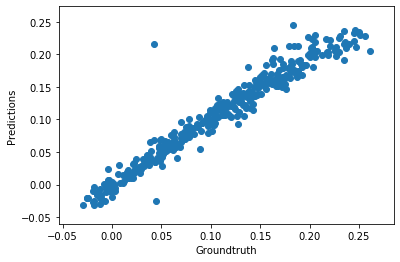

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [29]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5323943950582772
RMSE:  0.004034234018043151
The lowest error is:  4.515503291876999e-06
The highest error is:  0.023677065431281563
The avg. error is:  0.002935950341988387


In [30]:
model_fr_com_y.coef_

array([[-4.98024681e-04, -3.12250226e-17, -4.16333634e-17,
        -8.57600305e-03,  1.11022302e-16,  1.11022302e-16,
        -1.73524239e-01,  8.58471733e-02, -1.45135965e-01,
        -4.95910494e-01,  2.59773761e-01, -2.84247820e-01,
         3.09453809e-01,  2.55902230e-01]])

In [31]:
model_fr_com_y.intercept_

array([0.22172862])

Text(0, 0.5, 'Predictions')

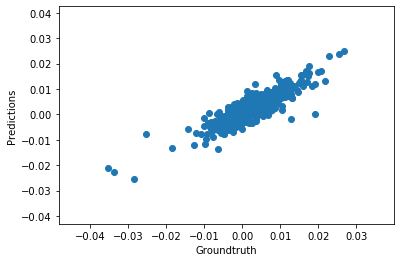

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [32]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.6716002796253655
RMSE:  0.0023308495890352926
The lowest error is:  1.4568128965265076e-05
The highest error is:  0.008182633788588238
The avg. error is:  0.0018235411536157917


In [33]:
model_fl_com_theta.coef_

array([[-4.30759868e-04, -2.60208521e-17, -2.60208521e-17,
         2.68842957e-03, -2.08166817e-17, -3.46944695e-18,
        -7.41039438e-02,  2.79472175e-02, -3.81684048e-02,
         2.83154415e-02, -1.50632364e-02, -1.72087663e-02,
         4.90469594e-02, -4.73424334e-02]])

In [34]:
model_fl_com_theta.intercept_

array([0.02805025])

Text(0, 0.5, 'Predictions')

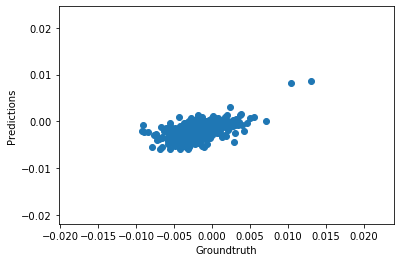

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")